In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle

plt.style.use('article.mplstyle')

In [11]:
X = np.loadtxt("save/X_2D.csv", delimiter=",")
Z = np.loadtxt("save/Z_2D.csv", delimiter=",")
intensity = np.loadtxt("save/intensity_2D.csv", delimiter=",")

def show_intensity_xOz(I, x, z, scatterers,  *arrow_directions, cmap='binary'):
    x_max = np.max(scatterers[:, 0])
    x_min = np.min(scatterers[:, 0])
    z_max = np.max(scatterers[:, 2])
    z_min = np.min(scatterers[:, 2])

    fig = plt.figure()
    ax = fig.add_subplot()

    surface = ax.pcolormesh(z, x, I, cmap=cmap, norm=LogNorm(vmin=np.min(I), vmax=np.max(I)), shading='gouraud')
    # cbar = fig.colorbar(surface, ax=ax)
    # cbar.set_label("$(|E|/E_0)^2$")

    # rect = Rectangle((z_min, x_min), width=z_max-z_min, height=x_max-x_min, linewidth=1.5, linestyle='--',
    #                  edgecolor='black', facecolor='none')
    # ax.add_patch(rect)

    # for direction in arrow_directions:
    #     plt.quiver(0, 0, direction[2], direction[0], angles='xy', scale=8)

    # plt.xlabel('$z ~ (\\lambda)$')
    # plt.ylabel("$x ~ (\\lambda)$")
    # ax.set_title(f"Stationnary intensity in the $xOz$ plane\n")

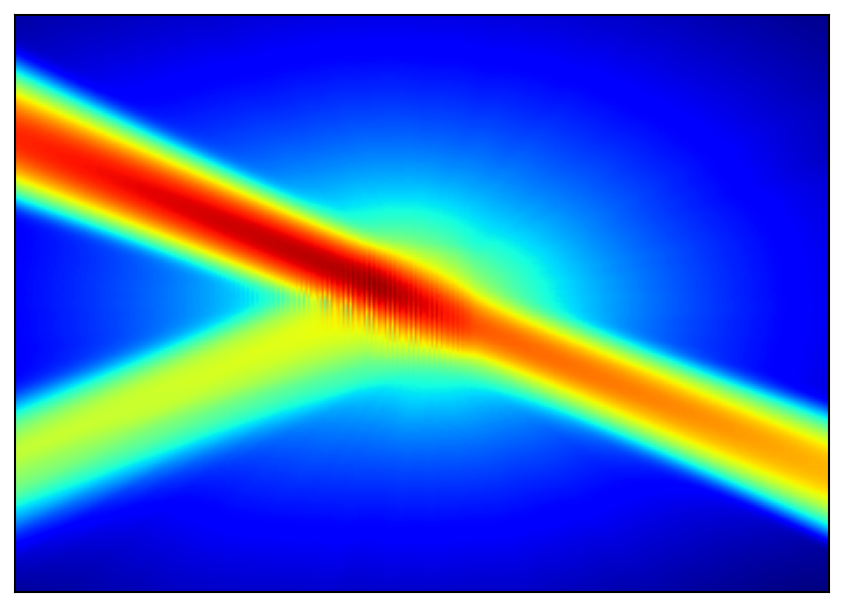

In [12]:
show_intensity_xOz(intensity, X, Z, X, [0, 0, 0], [0, 0, 0], cmap='jet')
plt.gca().set_facecolor('none')
plt.gcf().patch.set_facecolor('none')
plt.xticks([])
plt.yticks([])
plt.savefig("intensity.png", dpi=600, bbox_inches='tight')
plt.show()